In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/temp_data.csv')
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,FRSHTT,MAX,MIN,MXSPD,PRCP,SNDP,STP,TEMP
0,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-04,0,76.3,54.3,1.0,0.0,999.9,999.9,64.3
1,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-05,0,78.1,54.7,1.0,0.0,999.9,999.9,62.1
2,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-06,0,78.1,56.8,8.0,0.0,999.9,999.9,70.0
3,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-07,0,78.6,56.1,4.1,0.0,999.9,999.9,66.1
4,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-09,0,84.0,59.7,6.0,0.0,999.9,999.9,71.9


In [ ]:
df.info

<bound method DataFrame.info of            STATION       NAME   LATITUDE  LONGITUDE  ELEVATION        DATE  \
0      42452099999   KOTA, IN  25.160219  75.845631     273.10  2000-01-04   
1      42452099999   KOTA, IN  25.160219  75.845631     273.10  2000-01-05   
2      42452099999   KOTA, IN  25.160219  75.845631     273.10  2000-01-06   
3      42452099999   KOTA, IN  25.160219  75.845631     273.10  2000-01-07   
4      42452099999   KOTA, IN  25.160219  75.845631     273.10  2000-01-09   
...            ...        ...        ...        ...        ...         ...   
53365  42492099999  PATNA, IN  25.591317  85.087992      51.81  2022-11-01   
53366  42492099999  PATNA, IN  25.591317  85.087992      51.81  2022-11-02   
53367  42492099999  PATNA, IN  25.591317  85.087992      51.81  2022-11-03   
53368  42492099999  PATNA, IN  25.591317  85.087992      51.81  2022-11-04   
53369  42492099999  PATNA, IN  25.591317  85.087992      51.81  2022-11-05   

       FRSHTT   MAX   MIN  MXSP

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
STATION,53370.0,4.244478e+10,5.032858e+07,4.236910e+10,4.237910e+10,4.247510e+10,4.249210e+10,4.249810e+10
LATITUDE,53370.0,2.583136e+01,6.569256e-01,2.516022e+01,2.523333e+01,2.545000e+01,2.673971e+01,2.676059e+01
LONGITUDE,53370.0,8.248356e+01,3.437535e+00,7.584563e+01,8.088934e+01,8.286667e+01,8.508799e+01,8.832857e+01
ELEVATION,53370.0,1.114429e+02,7.285362e+01,4.900000e+01,5.181000e+01,8.108000e+01,1.249600e+02,2.731000e+02
FRSHTT,53370.0,1.177888e+04,2.965872e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,1.100100e+05
MAX,53370.0,8.983809e+01,1.110039e+01,4.950000e+01,8.260000e+01,9.140000e+01,9.680000e+01,1.191000e+02
MIN,53370.0,6.872484e+01,6.202461e+01,3.070000e+01,5.790000e+01,7.200000e+01,7.880000e+01,9.999900e+03
MXSPD,53370.0,6.525104e+01,2.351430e+02,1.000000e+00,2.900000e+00,6.000000e+00,9.900000e+00,9.999000e+02
PRCP,53370.0,4.824040e+00,2.121671e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.999000e+01
SNDP,53370.0,9.999000e+02,2.273758e-13,9.999000e+02,9.999000e+02,9.999000e+02,9.999000e+02,9.999000e+02


In [ ]:
# Let's drop STP(Station Pressure) and SNDP(Snow Depth) as they are probably erroneous

In [ ]:
df.pop('STP')
df.pop('SNDP')

0        999.9
1        999.9
2        999.9
3        999.9
4        999.9
         ...  
53365    999.9
53366    999.9
53367    999.9
53368    999.9
53369    999.9
Name: SNDP, Length: 53370, dtype: float64

In [ ]:
print(len(df))

53370


In [ ]:
list_place = list(set(df['NAME']))
list_place

['LUCKNOW, IN',
 'ALLAHABAD AIRPORT, IN',
 'BAGDOGRA, IN',
 'BHAGALPUR, IN',
 'GORAKHPUR, IN',
 'PATNA, IN',
 'ALLAHABAD, IN',
 'KOTA, IN',
 'LAL BAHADUR SHASTRI, IN']

In [ ]:
pip install plotly==5.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 7.7 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
df['STATION'].nunique()

8

In [ ]:
# station_codes = list(set(df['STATION']))
# station_codes

In [ ]:
# df = df.set_index('DATE')
# df.index = pd.to_datetime(df.index)

In [ ]:
df.isnull().sum()

STATION      0
NAME         0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
DATE         0
FRSHTT       0
MAX          0
MIN          0
MXSPD        0
PRCP         0
TEMP         0
dtype: int64

In [ ]:
select_coloumns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','DATE','FRSHTT','MAX','MIN','MXSPD','PRCP','TEMP']

In [ ]:
def call_the_station(df, name):
    temp_df = df[(df.NAME == name)]
    selected_station = temp_df[select_coloumns].copy()
    selected_station.reset_index(drop = True, inplace = True)
    return selected_station

def date_as_index(df):
    temp = df
    temp = temp.set_index('DATE', inplace= False)
    return temp

In [ ]:
Kota = call_the_station(df,'KOTA, IN') 
Kota_d = date_as_index(Kota)
Kota


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,FRSHTT,MAX,MIN,MXSPD,PRCP,TEMP
0,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-04,0,76.3,54.3,1.0,0.0,64.3
1,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-05,0,78.1,54.7,1.0,0.0,62.1
2,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-06,0,78.1,56.8,8.0,0.0,70.0
3,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-07,0,78.6,56.1,4.1,0.0,66.1
4,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-09,0,84.0,59.7,6.0,0.0,71.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8074,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-01,0,94.1,61.0,999.9,0.0,76.9
8075,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-02,0,95.5,62.6,1.9,0.0,79.5
8076,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-03,0,95.7,64.4,6.0,0.0,79.5
8077,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-04,0,98.6,67.6,2.9,0.0,81.5


###The dataframe Kota contains daily temparature readings from kota station since year 2000. Below is the visualization of the variation in temparature

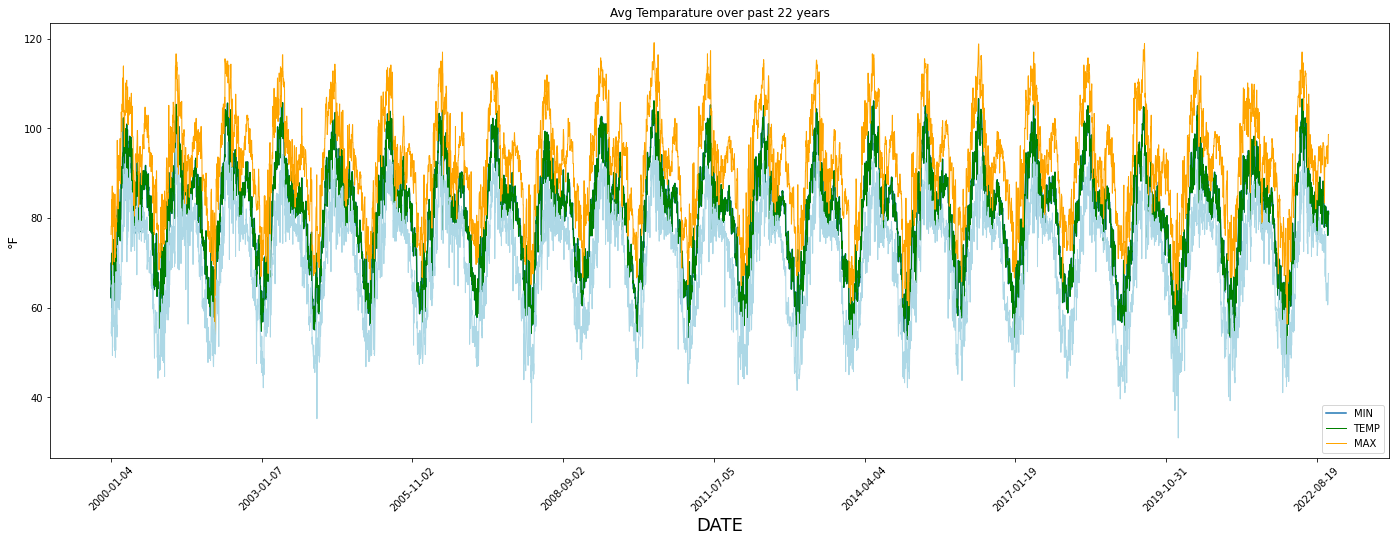

In [ ]:
plt.figure(figsize=(24,8))
ax = plt.gca()
Kota.plot(kind = 'line',
        x = 'DATE',
        y = 'TEMP',
         ax = ax)
plt.xticks(rotation = 45)
plt.ylabel('°F', fontsize=13)
plt.title('Avg Temparature over past 22 years')
plt.xlabel('DATE', fontsize=18)
plt.plot(Kota.TEMP, color = 'green',linewidth=1);
plt.plot(Kota.MAX, color = 'orange',linewidth=1);
plt.plot(Kota.MIN, color = 'lightblue',linewidth=1);
plt.legend(['MIN','TEMP','MAX'], loc = 'lower right');

In [ ]:
def correlation_matrix(df):
  correlation_matrix = Kota.corr()
  print(correlation_matrix)
  fig, ax = plt.subplots(figsize=(13,10))

  sns.heatmap(correlation_matrix,
                annot=True,
                fmt='.2f',
                #cmap='YlGnBu',
                ax=ax);
  plt.xticks(rotation = 45, fontsize=14)
  plt.yticks(fontsize=14);

           STATION  LATITUDE  LONGITUDE  ELEVATION    FRSHTT       MAX  \
STATION        NaN       NaN        NaN        NaN       NaN       NaN   
LATITUDE       NaN       NaN        NaN        NaN       NaN       NaN   
LONGITUDE      NaN       NaN        NaN        NaN       NaN       NaN   
ELEVATION      NaN       NaN        NaN        NaN       NaN       NaN   
FRSHTT         NaN       NaN        NaN        NaN  1.000000 -0.280500   
MAX            NaN       NaN        NaN        NaN -0.280500  1.000000   
MIN            NaN       NaN        NaN        NaN -0.184467  0.862942   
MXSPD          NaN       NaN        NaN        NaN  0.018186 -0.028244   
PRCP           NaN       NaN        NaN        NaN  0.114180  0.017244   
TEMP           NaN       NaN        NaN        NaN -0.255842  0.958373   

                MIN     MXSPD      PRCP      TEMP  
STATION         NaN       NaN       NaN       NaN  
LATITUDE        NaN       NaN       NaN       NaN  
LONGITUDE       NaN       NaN

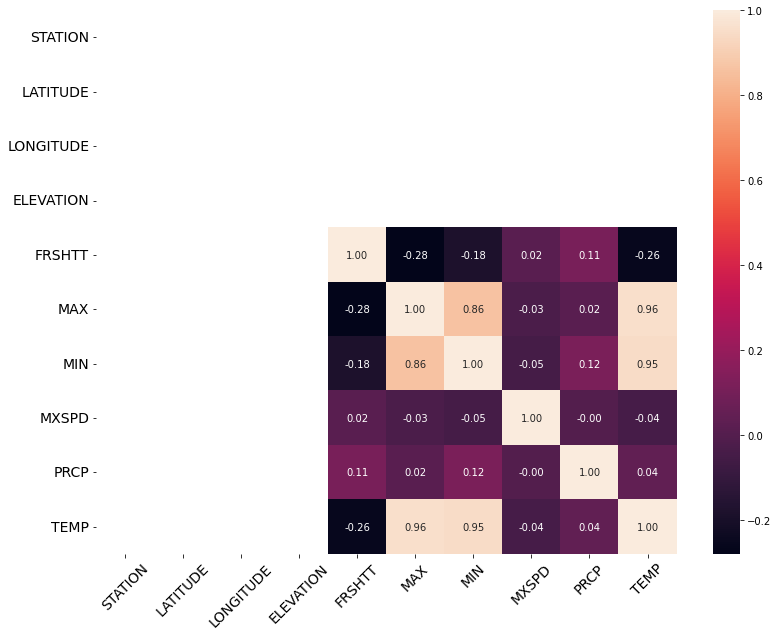

In [ ]:
correlation_matrix(df)

When forecasting or predicting the future, most time series models assume that each point is independent of one another. The best indication of this is when the dataset of past instances is stationary. For data to be stationary, the statistical properties of a system do not change over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant. From a purely visual assessment, time plots that do not show trends or seasonality can be considered stationary. Thogh we obviously know that we observe seasonality in the tempareture data let us perform ADF test.

# Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not

In [ ]:
from statsmodels.tsa.stattools import adfuller

Kota_adf = ts.adfuller(Kota.TEMP, maxlag=1, regression='ct')
print(Kota_adf)

(-10.379726166873287, 3.7344556505371846e-16, 0, 8078, {'1%': -3.9598911464773217, '5%': -3.411033639426721, '10%': -3.1273701394194804}, 38427.02195057978)


In [ ]:
print('Augmented Dickey-Fuller ADF Test Statistic: ', (Kota_adf[0], 6))
print('Augmented Dickey-Fuller ADF Test P-Value: ', (Kota_adf[1], 6))

Augmented Dickey-Fuller ADF Test Statistic:  (-10.379726166873287, 6)
Augmented Dickey-Fuller ADF Test P-Value:  (3.7344556505371846e-16, 6)


If the P-Value is less than the Significance Level defined, we reject the Null Hypothesis that the time series contains a unit root. In other words, by rejecting the Null hypothesis, we can conclude that the time series is stationary. As our p-value is less than 0.05 we consider it as stationary

#Creating features for training data


In [ ]:
def create_features_r(df):
  df = df.copy()
  df['PRCP'] = df.PRCP
  df['MAX'] = df.MAX
  df['MIN'] = df.MIN
  df['FRSHTT'] = df.FRSHTT
  return df


create_features_r(Kota)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,FRSHTT,MAX,MIN,MXSPD,PRCP,TEMP
0,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-04,0,76.3,54.3,1.0,0.0,64.3
1,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-05,0,78.1,54.7,1.0,0.0,62.1
2,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-06,0,78.1,56.8,8.0,0.0,70.0
3,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-07,0,78.6,56.1,4.1,0.0,66.1
4,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2000-01-09,0,84.0,59.7,6.0,0.0,71.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8074,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-01,0,94.1,61.0,999.9,0.0,76.9
8075,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-02,0,95.5,62.6,1.9,0.0,79.5
8076,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-03,0,95.7,64.4,6.0,0.0,79.5
8077,42452099999,"KOTA, IN",25.160219,75.845631,273.1,2022-11-04,0,98.6,67.6,2.9,0.0,81.5


In [ ]:
train_r = Kota.loc[Kota.index < 7713]
test_r = Kota.loc[Kota.index >= 7713]

In [ ]:
train_r= create_features_r(train_r)
test_r = create_features_r(test_r)

FEATURE = ['PRCP','MAX','MIN','FRSHTT']
TARGET = 'TEMP'

x_train_r = train_r[FEATURE]
y_train_r = train_r[TARGET]

X_test = test_r[FEATURE]
y_test_r = test_r[TARGET]

#Lasso Regression

In [ ]:
lasso_regression = Lasso()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(lasso_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(train_r[FEATURE], train_r['TEMP'])

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


In [ ]:
train_score_l= results['mean_train_score']
train_score_l

0      -3.203908
1      -3.203908
2      -3.203908
3      -3.203910
4      -3.204022
5      -3.215667
6      -4.098743
7     -82.474406
8    -121.884087
9    -122.385483
10   -128.540200
Name: mean_train_score, dtype: float64

In [ ]:
lasso_regression = Lasso(alpha = 100)
lasso_regression.fit(train_r[FEATURE], train_r['TEMP'])
y_test_pred = lasso_regression.predict(test_r[FEATURE])
y_train_pred = lasso_regression.predict(train_r[FEATURE])  
print(np.sqrt(mean_squared_error(train_r['TEMP'], y_train_pred)))
print(np.sqrt(mean_squared_error(test_r['TEMP'], y_test_pred)))

8.994631157412426
9.378041139508852


#Random Forest

In [ ]:
lin_reg = RandomForestRegressor(max_features = 0.5)
parameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[20,50,100,200,400]}

tscv = TimeSeriesSplit(n_splits=7)
clf = RandomizedSearchCV(lin_reg, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=2, return_train_score=True, n_iter=10, n_jobs = 2)
clf.fit(train_r[FEATURE], train_r['TEMP'])


results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


In [ ]:
train_score_rf= results['mean_train_score']
train_score_rf

0   -0.618010
1   -0.586491
2   -0.587861
3   -0.590328
4   -1.547880
5   -1.573375
6   -0.624285
7   -0.605976
8   -0.602182
9   -0.667769
Name: mean_train_score, dtype: float64

In [ ]:
clf.best_params_

{'n_estimators': 400, 'max_depth': 10}

In [ ]:
lin_reg_rf = RandomForestRegressor(max_depth = 10, n_estimators = 200, verbose=1, n_jobs = 3, max_features=0.5)
lin_reg_rf.fit(train_r[FEATURE], train_r['TEMP'])

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.9s finished


RandomForestRegressor(max_depth=10, max_features=0.5, n_estimators=200,
                      n_jobs=3, verbose=1)

In [ ]:
y_train_pred_l = lin_reg_rf.predict(train_r[FEATURE])
y_test_pred_l = lin_reg_rf.predict(test_r[FEATURE])
print(np.sqrt(mean_squared_error(train_r['TEMP'], y_train_pred_l)))
print(np.sqrt(mean_squared_error(test_r['TEMP'], y_test_pred_l)))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.2s finished


1.3958295655662585
1.7882947100680509


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
Kota = Kota.set_index('DATE')
Kota.index = pd.to_datetime(Kota.index)

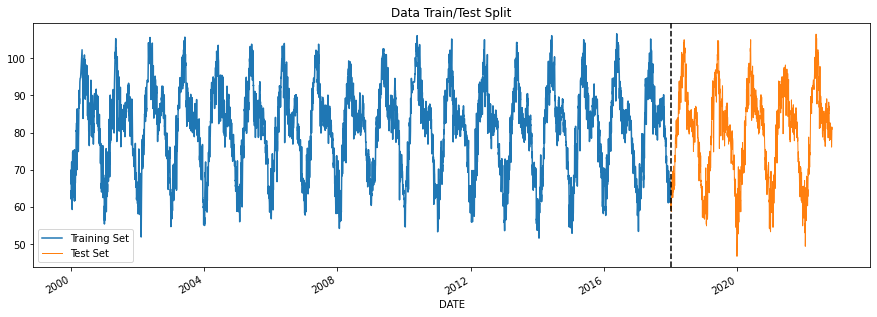

In [ ]:
train = Kota.loc[Kota.index < '01-01-2018']
test = Kota.loc[Kota.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.TEMP.plot(ax=ax, label='Training Set', title='Data Train/Test Split',linewidth=1.5)
test.TEMP.plot(ax=ax, label='Test Set',linewidth=1.0)
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
Kota.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,FRSHTT,MAX,MIN,MXSPD,PRCP,TEMP
DATE,,,,,,,,,,,
2000-01-04,42452099999,"KOTA, IN",25.160219,75.845631,273.1,0,76.3,54.3,1.0,0.0,64.3
2000-01-05,42452099999,"KOTA, IN",25.160219,75.845631,273.1,0,78.1,54.7,1.0,0.0,62.1
2000-01-06,42452099999,"KOTA, IN",25.160219,75.845631,273.1,0,78.1,56.8,8.0,0.0,70.0
2000-01-07,42452099999,"KOTA, IN",25.160219,75.845631,273.1,0,78.6,56.1,4.1,0.0,66.1
2000-01-09,42452099999,"KOTA, IN",25.160219,75.845631,273.1,0,84.0,59.7,6.0,0.0,71.9


# Cearting features for XGBoost

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['PRCP'] = df.PRCP
    df['MAX'] = df.MAX
    df['MIN'] = df.MIN
    df['FRSHTT'] = df.FRSHTT


    return df

Kota = create_features(Kota)

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'quarter', 'month', 'year','PRCP','MAX','MIN','FRSHTT']
TARGET = 'TEMP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Visualize relationship between month and temparature of kota station

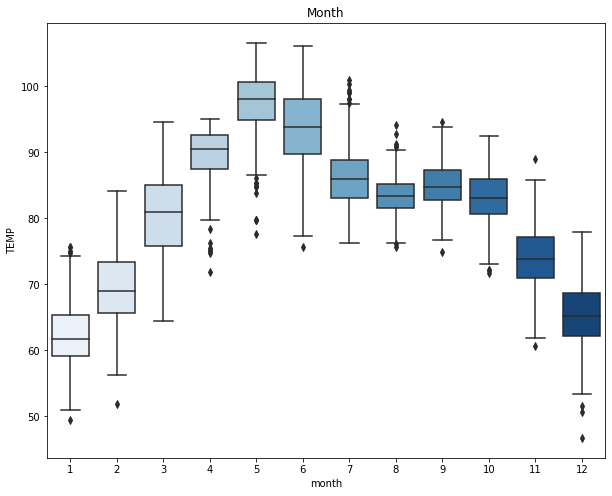

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Kota, x='month', y='TEMP', palette='Blues')
ax.set_title('Month')
plt.show()

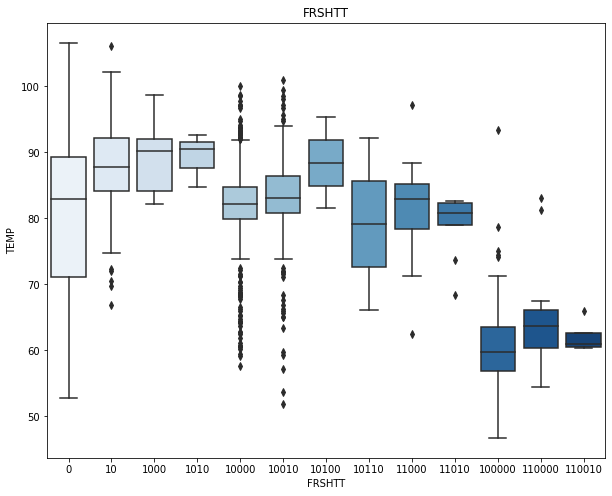

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Kota, x='FRSHTT', y='TEMP', palette='Blues')
ax.set_title('FRSHTT')
plt.show()

# Creating XGBost model

In [ ]:
# pytoch libraries (pip, import)
# dataloader object (dataframe ----> dataloader )
# 8000, --->6000
# lstM ------> (Inputs, [4 features]) (hidden state - (1 output)) (Cell state (-----))
# Train your model ----- epochs
# testing 

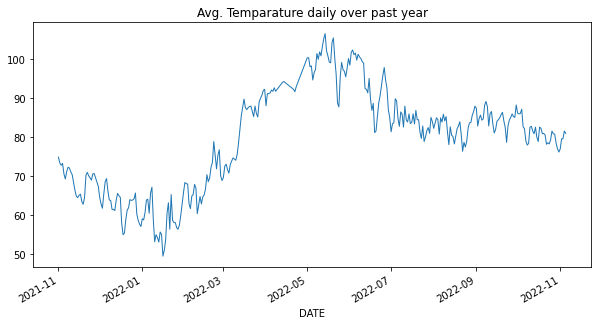

In [ ]:
tst = Kota.loc[Kota.index >= '11-01-2021']
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Avg. Temparature daily over past year')
tst.TEMP.plot(ax=ax, label='Tst Set', linewidth=1)
plt.show()

In [ ]:
! git clone --recursive https://github.com/dmlc/xgboost

Cloning into 'xgboost'...
remote: Enumerating objects: 55947, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 55947 (delta 43), reused 58 (delta 15), pack-reused 55821
Receiving objects: 100% (55947/55947), 24.26 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (35475/35475), done.
Submodule 'cub' (https://github.com/NVlabs/cub) registered for path 'cub'
Submodule 'dmlc-core' (https://github.com/dmlc/dmlc-core) registered for path 'dmlc-core'
Submodule 'gputreeshap' (https://github.com/rapidsai/gputreeshap.git) registered for path 'gputreeshap'
Cloning into '/content/xgboost/cub'...
remote: Enumerating objects: 38952, done.        
remote: Counting objects: 100% (296/296), done.        
remote: Compressing objects: 100% (162/162), done.        
remote: Total 38952 (delta 168), reused 234 (delta 131), pack-reused 38656        
Receiving objects: 100% (38952/38952), 20.44 MiB | 19.19 MiB/s, done.
Resolving deltas: 100%

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.02)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[05:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:79.6747	validation_1-rmse:78.7265
[100]	validation_0-rmse:10.7657	validation_1-rmse:10.3846
[200]	validation_0-rmse:2.15952	validation_1-rmse:2.22771
[300]	validation_0-rmse:1.58697	validation_1-rmse:1.88314
[400]	validation_0-rmse:1.54566	validation_1-rmse:1.86576
[500]	validation_0-rmse:1.5236	validation_1-rmse:1.86542
[600]	validation_0-rmse:1.50656	validation_1-rmse:1.86856
[700]	validation_0-rmse:1.48978	validation_1-rmse:1.87851
[800]	validation_0-rmse:1.47561	validation_1-rmse:1.87878
[900]	validation_0-rmse:1.46349	validation_1-rmse:1.87665
[1000]	validation_0-rmse:1.45309	validation_1-rmse:1.87652
[1100]	validation_0-rmse:1.44324	validation_1-rmse:1.88182
[1200]	validation_0-rmse:1.43392	validation_1-rmse:1.8836
[1300]	validation_0-rmse:1.42661	validation_1-rmse:1.88393
[1400]	validation_0-rmse:1.4192	validation_1-rmse:1.88376
[14

XGBRegressor(early_stopping_rounds=50, learning_rate=0.02, n_estimators=1500)

#Feature Importance

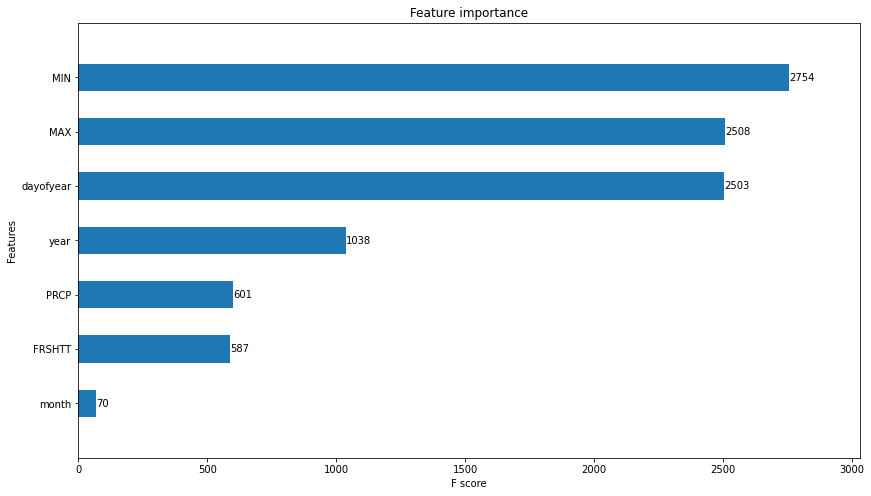

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
xgb.plot_importance(reg, max_num_features= 15, height=0.5, ax=ax, grid= False)
# ax.legend()
plt.show()

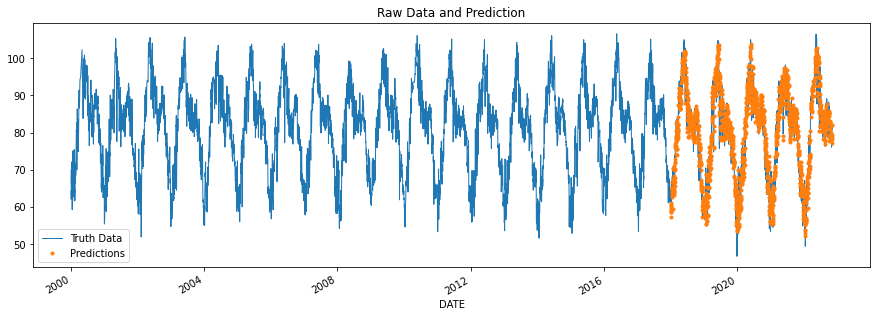

In [ ]:
test['prediction'] = reg.predict(X_test)
Kota = Kota.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = Kota[['TEMP']].plot(figsize=(15, 5),linewidth = 1)
Kota['prediction'].plot(ax=ax, style='.',linewidth = 1)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

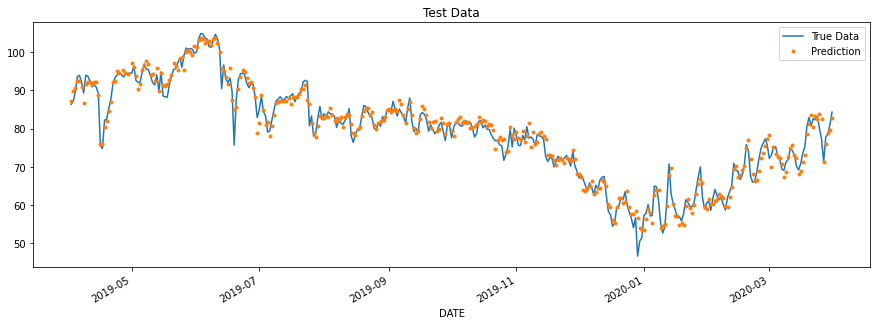

In [ ]:
ax = Kota.loc[(Kota.index > '04-01-2019') & (Kota.index < '04-01-2020')]['TEMP'] \
    .plot(figsize=(15, 5), title='Test Data')
Kota.loc[(Kota.index > '04-01-2019') & (Kota.index < '04-01-2020')]['prediction'] \
    .plot(style='.')
plt.legend(['True Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['TEMP'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.5f}')

RMSE Score on Test set: 1.88577


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2019-12-29    9.844067
2019-06-19    9.107983
2021-05-17    8.189732
2020-12-28    8.032505
2021-03-17    7.647859
2018-06-19    7.505586
2018-04-01    6.849707
2020-01-14    6.826447
2019-02-15    6.512639
2021-06-19    6.467223
Name: error, dtype: float64

Performing time series cross validation on the above model

In [ ]:
tss = TimeSeriesSplit(n_splits=7, test_size=365*1, gap=30)
Kota = Kota.sort_index()

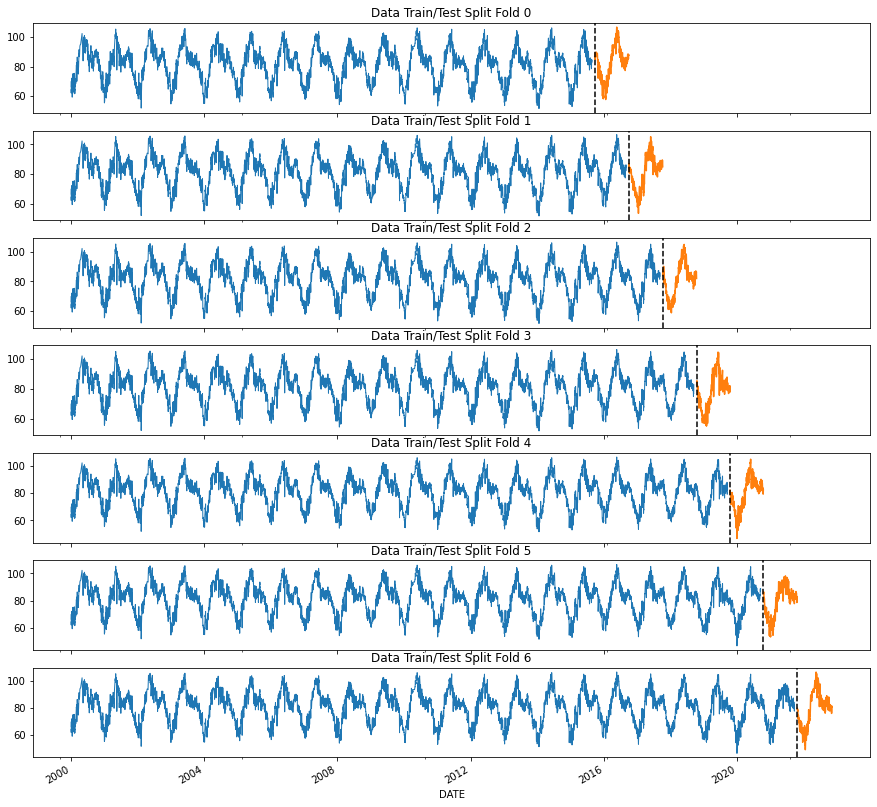

In [ ]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(Kota):
    train = Kota.iloc[train_idx]
    test = Kota.iloc[val_idx]
    train['TEMP'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',linewidth=1)
    test['TEMP'].plot(ax=axs[fold],
                         label='Test Set',linewidth=1.5)
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss = TimeSeriesSplit(n_splits=7, test_size=365*1, gap=30)
Kota = Kota.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(Kota):
    train = Kota.iloc[train_idx]
    test = Kota.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'quarter', 'month', 'year','PRCP','MAX','MIN','FRSHTT']
    TARGET = 'TEMP'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    regr = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.02)
    regr.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = regr.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[05:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:79.7359	validation_1-rmse:80.4999
[100]	validation_0-rmse:10.7755	validation_1-rmse:11.1397
[200]	validation_0-rmse:2.15278	validation_1-rmse:2.38989
[300]	validation_0-rmse:1.57546	validation_1-rmse:1.7261
[400]	validation_0-rmse:1.53583	validation_1-rmse:1.67398
[500]	validation_0-rmse:1.51125	validation_1-rmse:1.65857
[600]	validation_0-rmse:1.49151	validation_1-rmse:1.64968
[700]	validation_0-rmse:1.47439	validation_1-rmse:1.64285
[800]	validation_0-rmse:1.46034	validation_1-rmse:1.63878
[900]	validation_0-rmse:1.44864	validation_1-rmse:1.63433
[1000]	validation_0-rmse:1.43935	validation_1-rmse:1.63257
[1100]	validation_0-rmse:1.43037	validation_1-rmse:1.6339
[1200]	validation_0-rmse:1.42181	validation_1-rmse:1.62831
[1300]	validation_0-rmse:1.41385	validation_1-rmse:1.62647
[1400]	validation_0-rmse:1.40599	validation_1-rmse:1.62247
[1

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.8669
Fold scores:[1.6206987921962044, 1.9523231807270394, 1.8667566083802687, 2.0869995988023, 1.921452665056021, 1.9226113846229242, 1.697756629034939]


Prection through Auto Regressive Integrated Moving Average

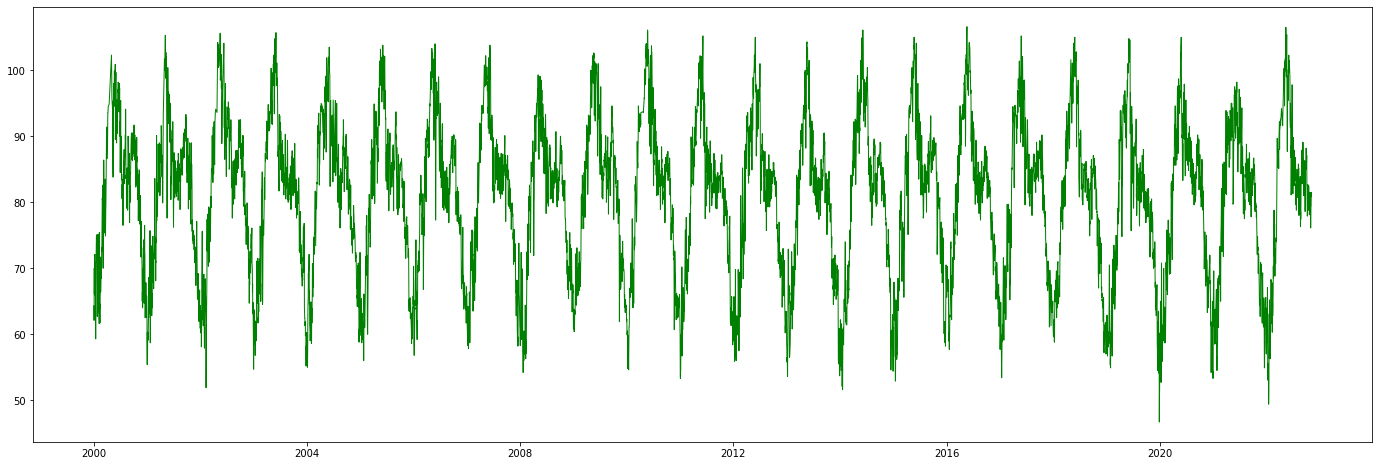

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(Kota.TEMP, color = 'green',linewidth=1);

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
# import statsmodels.api as sm

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(Kota[TARGET], trace=True,
suppress_warnings=True)

ImportError: ignored

In [ ]:
train = Kota.loc[Kota.index < '01-01-2018']
test = Kota.loc[Kota.index >= '01-01-2018']
print(len(train),test.shape)

In [ ]:
# import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['TEMP'], order=(3,0,2))
result = model.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   TEMP   No. Observations:                 6340
Model:                     ARMA(3, 2)   Log Likelihood              -14965.274
Method:                       css-mle   S.D. of innovations              2.563
Date:                Wed, 30 Nov 2022   AIC                          29944.549
Time:                        11:05:24   BIC                          29991.831
Sample:                             0   HQIC                         29960.923
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.4246      2.104     38.218      0.000      76.300      84.549
ar.L1.TEMP     1.8637      0.147     12.642      0.000       1.575       2.153
ar.L2.TEMP    -1.1231      0.251     -4.478      0.000      -1.615      -0.632
ar.L3.TEMP     0.2561      0.105      2.440      0.015       0.050       0.462
ma.L1.TEMP    -0.9320      0.151     -6.168      0.000      -1.228      -0.636
ma.L2.TEMP     0.1538      0.128      1.202      0.229      -0.097       0.405
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0087           -0.0000j            1.0087           -0.0000
AR.2            1.6885           -1.0100j            1.9675           -0.0858
AR.3            1.6885           +1.0100j            1.9675            0.0858
MA.1            1.3936           +0.0000j            1.3936            0.0000
MA.2            4.6641           +0.0000j            4.6641            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   TEMP   No. Observations:                 6340
Model:                     ARMA(3, 2)   Log Likelihood              -14965.274
Method:                       css-mle   S.D. of innovations              2.563
Date:                Wed, 30 Nov 2022   AIC                          29944.549
Time:                        11:05:26   BIC                          29991.831
Sample:                             0   HQIC                         29960.923
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.4246      2.104     38.218      0.000      76.300      84.549
ar.L1.TEMP     1.8637      0.147     12.642      0.000       1.575       2.153
ar.L2.TEMP    -1.1231      0.251     -4.478      0.000      -1.615      -0.632
ar.L3.TEMP     0.2561      0.105      2.440      0.015       0.050       0.462
ma.L1.TEMP    -0.9320      0.151     -6.168      0.000      -1.228      -0.636
ma.L2.TEMP     0.1538      0.128      1.202      0.229      -0.097       0.405
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0087           -0.0000j            1.0087           -0.0000
AR.2            1.6885           -1.0100j            1.9675           -0.0858
AR.3            1.6885           +1.0100j            1.9675            0.0858
MA.1            1.3936           +0.0000j            1.3936            0.0000
MA.2            4.6641           +0.0000j            4.6641            0.0000
-----------------------------------------------------------------------------
"""

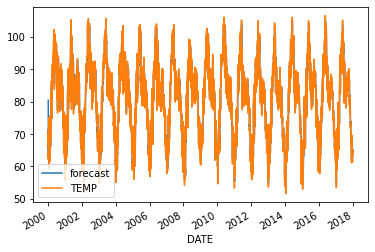

In [ ]:
result.plot_predict(dynamic=False)

plt.show()

#Creating a DNN model with LSTM hidden layers

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format,linewidth = 1)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

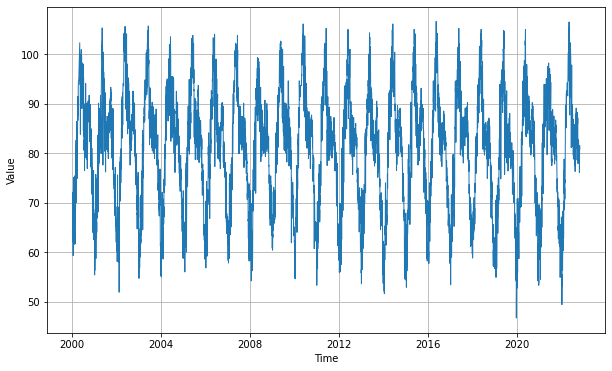

In [ ]:
series = np.array(Kota['TEMP'])
time = np.array(Kota.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
len(time)

8079

In [ ]:
split_time = 6500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
import tensorflow as tf


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(6500,)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


26/26 [==============================] - 19s 561ms/step - loss: 61.7215 - mae: 62.2215 - lr: 1.0000e-08
Epoch 2/100
26/26 [==============================] - 11s 413ms/step - loss: 52.5654 - mae: 53.0654 - lr: 1.1220e-08
Epoch 3/100
26/26 [==============================] - 10s 389ms/step - loss: 42.0515 - mae: 42.5515 - lr: 1.2589e-08
Epoch 4/100
26/26 [==============================] - 16s 628ms/step - loss: 30.3985 - mae: 30.8984 - lr: 1.4125e-08
Epoch 5/100
26/26 [==============================] - 15s 555ms/step - loss: 17.8332 - mae: 18.3294 - lr: 1.5849e-08
Epoch 6/100
26/26 [==============================] - 10s 384ms/step - loss: 9.9035 - mae: 10.3902 - lr: 1.7783e-08
Epoch 7/100
26/26 [==============================] - 10s 385ms/step - loss: 8.8406 - mae: 9.3231 - lr: 1.9953e-08
Epoch 8/100
26/26 [==============================] - 10s 390ms/step - loss: 8.6328 - mae: 9.1158 - lr: 2.2387e-08
Epoch 9/100
26/26 [==============================] - 10s 392ms/step - loss: 8.5025 - mae:

In [ ]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)
# train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=60, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),
#   tf.keras.layers.LSTM(60, return_sequences=True),
#   tf.keras.layers.LSTM(60, return_sequences=True),
#   tf.keras.layers.Dense(30, activation="relu"),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
# ])


# optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set,epochs=100)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

251/251 [==============================] - 13s 42ms/step


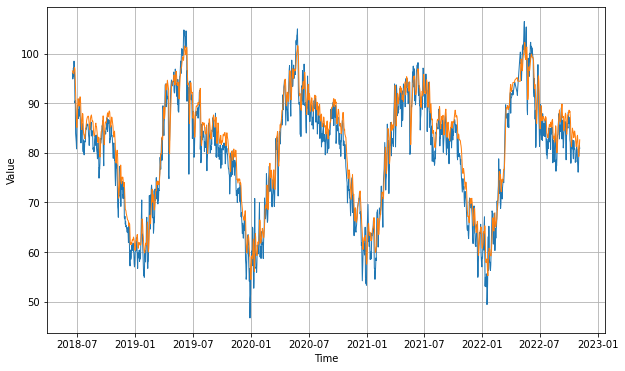

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.825643

#Let's predict Avg daily temparature in 2023

In [ ]:
predict_Kota = create_features(Kota)
FEATURES = ['dayofyear', 'quarter', 'month', 'year','PRCP','MAX','MIN','FRSHTT']
TARGET = 'TEMP'

X_all = Kota[FEATURES]
y_all = Kota[TARGET]

# reg = xgb.XGBRegressor(base_score=0.5,
#                        booster='gbtree',    
#                        n_estimators=1000,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.02)
regr.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[11:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:79.4737
[100]	validation_0-rmse:10.7443
[200]	validation_0-rmse:2.19831
[300]	validation_0-rmse:1.63826
[400]	validation_0-rmse:1.59975
[500]	validation_0-rmse:1.57704
[600]	validation_0-rmse:1.56016
[700]	validation_0-rmse:1.54697
[800]	validation_0-rmse:1.53545
[900]	validation_0-rmse:1.52429
[1000]	validation_0-rmse:1.51421
[1100]	validation_0-rmse:1.50389
[1200]	validation_0-rmse:1.49524
[1300]	validation_0-rmse:1.4867
[1400]	validation_0-rmse:1.47874
[1499]	validation_0-rmse:1.47149


XGBRegressor(early_stopping_rounds=50, learning_rate=0.02, n_estimators=1500)

In [ ]:
Kota.index.max()

Timestamp('2022-11-05 00:00:00')

In [ ]:
future = pd.date_range('2022-11-05','2023-11-05', freq='d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
predict_Kota['isFuture'] = False
predict_Kota_and_future = pd.concat([predict_Kota, future_df])
predict_Kota_and_future = create_features(predict_Kota_and_future)

In [ ]:
future_w_features = predict_Kota_and_future.query('isFuture').copy()
future_w_features['pred'] = regr.predict(future_w_features[FEATURES])

In [ ]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

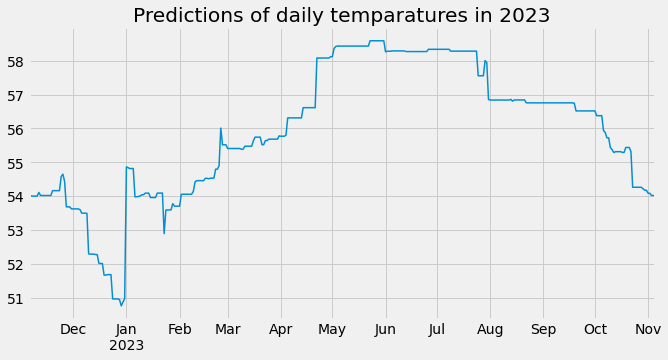

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               title='Predictions of daily temparatures in 2023',linewidth=1.5)
plt.show()